In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.signal import filtfilt, cheby1, butter, lombscargle, argrelmax, welch, periodogram
import pickle
from scipy.stats import pearsonr
import pandas as pd
import netCDF4 as nc
from datetime import date, timedelta

In [2]:
# Define Chebbyshev filter
def cheby_lowpass(cutoff, fs, order, rp):  
    nyq = 0.5 * fs
    normal_cutoff = cutoff/ nyq
    b, a = cheby1(order, rp, normal_cutoff, btype = "low", analog = False)
    return b, a
def cheby_lowpass_filter(x, cutoff, fs, order, rp):
    b, a = cheby_lowpass(cutoff, fs, order ,rp)
    y = filtfilt(b, a, x)
    return y


In [3]:
# Find the index of JJA dates in the time series of length = 6940
def JJA_date_generate(y1, y2):
    """y1 start year, y2 end year and generate the dates for JJA"""
    years = range(y1, y2+1)
    JJA_dates = []
    start = date(y1, 1, 1)
    for y in years:
        now = date(y, 6, 1)
        for n in range(92):
            delta = now - start
            JJA_dates.append(delta.days)
            now += timedelta(days=1)
    return JJA_dates
JJA = JJA_date_generate(1998, 2016)

# find index of JJAS 
def JJAS_date_generate(y1, y2):
    """y1 start year, y2 end year and generate the dates for JJA"""
    years = range(y1, y2+1)
    JJA_dates = []
    start = date(y1, 1, 1)
    for y in years:
        now = date(y, 6, 1)
        for n in range(122):
            delta = now - start
            JJA_dates.append(delta.days)
            now += timedelta(days=1)
    return JJA_dates
JJAS = JJA_date_generate(1998, 2016)

In [4]:
#try one file
nc_file = "D:/ic/urop/data/raw data/trmm_extra/20161108.nc4"
sigdata = nc.Dataset(nc_file)

lat = sigdata.variables['lat'][:]
lon = sigdata.variables['lon'][:]
#SCA
n25 = np.abs(lat - 25).argmin().item()
n32 = np.abs(lat - 32).argmin().item()
e71 = np.abs(lon - 71).argmin().item()
e88 = np.abs(lon - 88).argmin().item()
#EURO
n42 = np.abs(lat - 42).argmin().item()
n50 = np.abs(lat - 50).argmin().item()
e03 = np.abs(lon - 3).argmin().item()
e15 = np.abs(lon - 15).argmin().item()

In [5]:
print(lon)

[-179.875 -179.625 -179.375 ...  179.375  179.625  179.875]


In [6]:
monsoon_indices = np.zeros(2, dtype = 'object')
list_asia = []
for i in range(e71, e88):
    for j in range(n25, n32):
        list_asia.append((i, j))  # index in the matrix that contain SCA
        
list_eu = []
for i in range(e03, e15):
    for j in range(n42, n50):
        list_eu.append((i, j))  # index in the matrix that contain EU

monsoon_indices[0] = np.array(list_asia)
monsoon_indices[1] = np.array(list_eu)

In [7]:
#define parameters
monsoons = ['NISM','EUR']
syncs = ['ISM1-EUR']
sync_pairs = [[0, 1]]
taumax = 10

In [ ]:
# import ERE date list
with open("ERE_start_all_days", "rb") as fp:   # Unpickling
    start_date_ERE = pickle.load(fp)

In [9]:
#---------------------------METHOD 1---------------------------------
# Create two time series
ESAB = np.zeros(6940)
ESBA = np.zeros(6940)

In [ ]:
A = [x[n25:n32] for x in start_date_ERE[e71:e88]]
B = [x[n42:n50] for x in start_date_ERE[e03:e15]]

In [8]:
'''
with open("4b_A", "wb") as fp:   #Pickling
   pickle.dump(A, fp) 
with open("4b_B", "wb") as fp:   #Pickling
   pickle.dump(B, fp) 
'''
with open("4b_A", "rb") as fp:   # Unpickling
    A = pickle.load(fp)
with open("4b_B", "rb") as fp:   # Unpickling
    B = pickle.load(fp)

In [10]:
# generate index in time series of specific months
def date_generate(y1, y2, month):
    """y1 start year, y2 end year and generate the dates for JJA"""
    years = range(y1, y2+1)
    JJAS_dates = []
    start = date(y1, 1, 1)
    for y in years:
        now = date(y, month, 1) - start
        # print(type(now))
        # print(now.days)
        end = date(y, month+1, 1) - start
        # print(end.days)
        for k in range(now.days, end.days):
            JJAS_dates.append(k)
    return JJAS_dates

june = date_generate(1998, 2016, 6)
july = date_generate(1998, 2016, 7)
aug = date_generate(1998, 2016, 8)
sep = date_generate(1998, 2016, 9)

In [12]:
Adates_n = []
for target in range(6940):
    index = []
    for i in range(len(A)):
        for j in range(len(A[i])):
            if target in A[i][j]:
                index.append((i, j, A[i][j].index(target)))
    Adates_n.append(index)

Bdates_n = []
for target in range(6940):
    index = []
    for i in range(len(B)):
        for j in range(len(B[i])):
            if target in B[i][j]:
                index.append((i, j, B[i][j].index(target)))
    Bdates_n.append(index)


In [13]:
tau_max = 10
length = 6940

In [14]:
#ESAB/ t12
for i in range(length):
    es = 0
    mu_indexes = Adates_n[i]#indexes of EREs in A happenes in day i
    #print(mu_indexes)  
    nu_indexes = []
    for j in range(i, min(length,i+tau_max+1)):
        nu_indexes.append(Bdates_n[j])#index of nu in B for nu to be EREs happened within tau_max days before mu
    #print(nu_indexes)
    for mu_index in mu_indexes:#loop over mu in day i
        mu_index_x, mu_index_y, mu_index_z = mu_index
        mu = A[mu_index_x][mu_index_y][mu_index_z]
        #print(mu)
        if mu_index_z == 0:
            t_1 = 10**10
        else:
            t_1 = mu - A[mu_index_x][mu_index_y][mu_index_z - 1]
        if len(A[mu_index_x][mu_index_y]) == mu_index_z+1:
            t_2 = 10**10
        else:
            t_2 = A[mu_index_x][mu_index_y][mu_index_z + 1] - mu              
        for nu_i in nu_indexes:#different day 
            for nu_index in nu_i:#nu in a single day
                nu_index_x, nu_index_y, nu_index_z = nu_index
                nu = B[nu_index_x][nu_index_y][nu_index_z]
                if nu_index_z == 0:
                    t_3 = 10**10
                else:
                    t_3 = nu - B[nu_index_x][nu_index_y][nu_index_z - 1]
                if len(B[nu_index_x][nu_index_y])== nu_index_z+1:
                    t_4 = 10**10
                else:
                    t_4 = B[nu_index_x][nu_index_y][nu_index_z + 1] - nu 
                tau = min(t_1, t_2, t_3, t_4)/2
                if  -tau < -nu_indexes.index(nu_i):
                    es += 1
    ESAB[i] = es
              

In [15]:
#ESBA/ t21
for i in range(length):
    es = 0
    nu_indexes = Bdates_n[i]#indexes of EREs in B happenes in day i
    #print(mu_indexes)  
    mu_indexes = []
    for j in range(i+1, min(length,i+tau_max+1)):
        mu_indexes.append(Adates_n[j])#index of mu in A for mu to be EREs happened within tau_max days after nu
    #print(nu_indexes)
    for nu_index in nu_indexes:#loop over nu in day i
        nu_index_x, nu_index_y, nu_index_z = nu_index
        nu = B[nu_index_x][nu_index_y][nu_index_z]  # nu is date of that specific ERE
        if nu_index_z == 0:
            t_1 = 10**10
        else:
            t_1 = nu - B[nu_index_x][nu_index_y][nu_index_z - 1]
        if len(B[nu_index_x][nu_index_y]) == nu_index_z+1:
            t_2 = 10**10
        else:
            t_2 = B[nu_index_x][nu_index_y][nu_index_z + 1] - nu
        for mu_i in mu_indexes:  # different day 
            for mu_index in mu_i: # mu in a single day
                mu_index_x, mu_index_y, mu_index_z = mu_index
                mu = A[mu_index_x][mu_index_y][mu_index_z]
                if mu_index_z == 0:
                    t_3 = 10**10
                else:
                    t_3 = mu - A[mu_index_x][mu_index_y][mu_index_z - 1]
                if len(A[mu_index_x][mu_index_y])== mu_index_z+1:
                    t_4 = 10**10
                else:
                    t_4 = A[mu_index_x][mu_index_y][mu_index_z + 1] - mu 
                tau = min(t_1, t_2, t_3, t_4, 20)/2
                if  (mu_indexes.index(mu_i)+1) < tau:
                    es += 1
    ESBA[i] = es

In [16]:
sync_times = np.zeros((1,2), dtype = 'object')
monsoon_times = np.zeros(len(monsoons))

In [17]:
# Apply chebyshev filter and find the local maximum > 90% of JJA data
cutoff = 10
sth = 90
rmt_12 = cheby_lowpass_filter(ESAB, .95 * 1. / cutoff, 1, 8, .05)
# plt.plot(rmt_12)
locmax_12 = np.array(argrelmax(rmt_12)[0])
sync_times[0, 0] = np.intersect1d(locmax_12, np.where(rmt_12 > st.scoreatpercentile(rmt_12[JJA], sth))[0])


In [19]:
rmt_21 = cheby_lowpass_filter(ESBA, .95 * 1. / cutoff, 1, 8, .05)
# plt.plot(rmt_12)
locmax_21 = np.array(argrelmax(rmt_21)[0])
sync_times[0, 1] = np.intersect1d(locmax_21, np.where(rmt_21 > st.scoreatpercentile(rmt_21[JJA], sth))[0])

In [20]:
# Create a dictionary, keys = date of local max, values = value of local maximum 
print(sync_times[0,1])
BA_locmax_dict = {}
for i in sync_times[0,1]:
    BA_locmax_dict[i] = rmt_21[i]
print(sorted(list(BA_locmax_dict.values()), reverse= True))

[ 566  626  758  915 1281 1293 1497 1681 2407 2448 2767 2806 3107 3149
 3179 3327 3475 3488 3506 3527 3547 3875 3907 4214 4263 4418 4579 4609
 4620 4632 4643 4919 4941 4994 5296 5368 5510 5638 5650 5687 5698 5757
 5859 6045 6053 6064 6086 6127 6429 6464 6750 6767 6778 6790 6833]
[33149.89578890015, 25524.241283757638, 25255.436245360015, 24636.997577689166, 23043.412979327528, 22310.94252905585, 20939.768490856826, 18647.143767973263, 17907.57978454897, 17274.83977792899, 16108.643668417913, 15492.917472247686, 15411.60813342381, 14305.100584644926, 13917.769615467645, 12812.817448761152, 12701.597679929362, 12395.923183227796, 12385.545369550833, 12016.725293335618, 11718.084110984768, 11616.621566426536, 11370.043034589931, 11351.297312407572, 11124.240453080633, 11072.488447496613, 10874.299264976558, 10725.31166093475, 10585.161269230892, 10580.80377475638, 10580.541002912527, 10552.884915426373, 10496.561200026925, 10488.016666869797, 10409.55093896745, 10117.21592367044, 9959.940

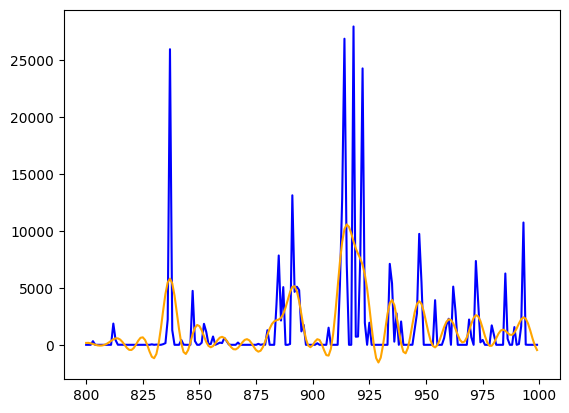

In [21]:
# plot t21(ESBA) before and after chebyshev filter
plt.plot(range(800, 1000), ESBA[800:1000], color = "blue")
plt.plot(range(800, 1000), rmt_21[800:1000], color = "orange")

In [22]:
print(sync_times)

[[array([  87,  184,  264,  276,  289,  625,  655,  812,  888,  915,  988,
         1277, 1288, 1502, 1682, 1707, 2025, 2406, 2419, 2806, 3147, 3173,
         3187, 3327, 3357, 3472, 3501, 3526, 3531, 3866, 3876, 4212, 4295,
         4576, 4595, 4606, 4629, 4643, 4925, 4940, 5004, 5345, 5367, 5495,
         5513, 5645, 5722, 5754, 5765, 6029, 6041, 6053, 6065, 6096, 6129,
         6281, 6428, 6472, 6768, 6853], dtype=int64)
  array([ 566,  626,  758,  915, 1281, 1293, 1497, 1681, 2407, 2448, 2767,
         2806, 3107, 3149, 3179, 3327, 3475, 3488, 3506, 3527, 3547, 3875,
         3907, 4214, 4263, 4418, 4579, 4609, 4620, 4632, 4643, 4919, 4941,
         4994, 5296, 5368, 5510, 5638, 5650, 5687, 5698, 5757, 5859, 6045,
         6053, 6064, 6086, 6127, 6429, 6464, 6750, 6767, 6778, 6790, 6833],
        dtype=int64)                                                       ]]


In [23]:
def days_in_month(year, month):
    if month in [4, 6, 9, 11]:  # April, June, September, November
        return 30
    elif month == 2:  # February
        if year % 400 == 0 or (year % 100 != 0 and year % 4 == 0):
            return 29  # Leap year
        else:
            return 28  # Non-leap year
    else:
        return 31  # January, March, May, July, August, October, December
ESABnew = []
ESBAnew = []
current_index = 0

for year in range(1998, 2017):
    for month in range(1, 13):
        days = days_in_month(year, month)
        for day in range(1, days + 1):
            if month in [6, 7, 8,9]:  # If it's June, July, or August, add the data from expanded_nested_list
                ESABnew.append(ESAB[current_index])
                ESBAnew.append(ESBA[current_index])
            current_index += 1

In [24]:
# Find the date in JJAS months over 1998-2016
def date_generate(y1, y2, month):
    """y1 start year, y2 end year and generate the dates for JJA"""
    years = range(y1, y2+1)
    JJAS_dates = []
    start = date(y1, 1, 1)
    for y in years:
        now = date(y, month, 1) - start
        # print(type(now))
        # print(now.days)
        end = date(y, month+1, 1) - start
        # print(end.days)
        for k in range(now.days, end.days):
            JJAS_dates.append(k)
    return JJAS_dates

june = date_generate(1998, 2016, 6)
july = date_generate(1998, 2016, 7)
aug = date_generate(1998, 2016, 8)
sep = date_generate(1998, 2016, 9)

#Find the number non-zero dates of t21(ESBA) in each of the four months
freqABJJAS = np.zeros(4)
freqBAJJAS = np.zeros(4)

freqBAJJAS[0] += np.count_nonzero(ESBA[june]) 
freqBAJJAS[1] += np.count_nonzero(ESBA[july])
freqBAJJAS[2] += np.count_nonzero(ESBA[aug])
freqBAJJAS[3] += np.count_nonzero(ESBA[sep])


<BarContainer object of 4 artists>

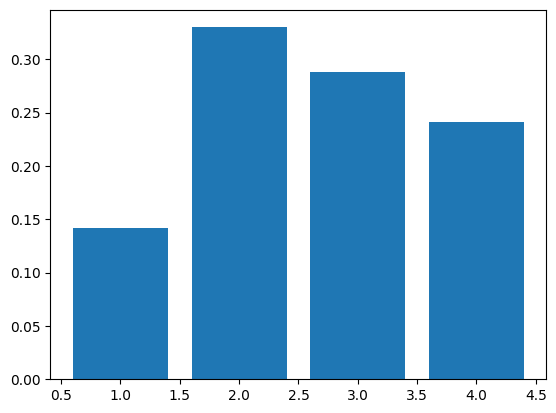

In [25]:
plt.bar([1,2,3,4], freqBAJJAS/np.sum(freqBAJJAS), width=0.8)

In [ ]:
#--------------Method 2: Using author's method to calculate t21, t, t12------------
A = [x[n25:n32] for x in start_date_ERE[e71:e88]]
B = [x[n42:n50] for x in start_date_ERE[e03:e15]]
gridNA = len(A)*len(A[0])
gridNB = len(B)*len(B[0])
NERE = int(6940*0.05)
E1 = np.zeros((gridNA, NERE))
E2 = np.zeros((gridNB, NERE))
k=0
for i in A:
    for j in i:
        E1[k,:len(j)] = j
        k += 1
k=0
for i in B:
    for j in i:
        E2[k,:len(j)] = j
        k += 1

In [ ]:
def ESreg(e1, e2, t, t12, t21, taumax, tlen):
    delay12 = 0
    delay21 = 0
    mnoe = e1.shape[1]
    n1 = e1.shape[0]
    n2 = e2.shape[0]
    for i in range(n1):
        for j in range(n2):
            for m in range(1, mnoe - 1):
                if e1[i, m] > 0:
                    for n in range(1, mnoe - 1):
                        if e2[j, n] > 0:
                            dst = e1[i, m] - e2[j, n]
                            if dst > taumax:
                                continue
                            tau = min([e1[i, m] - e1[i, m - 1], e1[i, m + 1] - e1[i, m], e2[j, n] - e2[j, n - 1], e2[j, n + 1] - e2[j, n]]) / 2.
                            if dst < 0 and abs(dst) < tau and abs(dst) < taumax:
                                t12[int(e1[i, m])] += 1
                                delay12 += abs(dst)
                            elif dst == 0:
                                t[int(e1[i, m])] += 1
                            elif dst > 0 and abs(dst) < tau and abs(dst) < taumax:
                                t21[int(e2[j, n])] += 1
                                delay21 += abs(dst)
                            if dst < -taumax:
                                break
    return t, t12, t21


In [ ]:
t = np.zeros((1, 6940))
t12 = np.zeros((1, 6940))
t21 = np.zeros((1, 6940))
t[0], t12[0], t21[0] = ESreg(E1, E2, t, t12, t21, 10, 6940)

In [28]:
# store these three time seires in time_series.values in t.pkl
# time_series={}
# time_series[0] = t
# time_series[1] = t12
# time_series[2] = t21
#with open("t.pkl", "rb") as fp:   # Unpickling
#    time_series = pickle.dump(fp)

In [29]:
t, t12, t21 = time_series.values()

In [30]:
print(t)

[[0. 0. 0. ... 0. 0. 0.]]


In [31]:
freqABJJAS = np.zeros(4)
freqBAJJAS = np.zeros(4)
# find the sum of loc max of t21 in four months
for i in june:
    freqBAJJAS[0] += t21[0][i] 
for i in july:
    freqBAJJAS[1] += t21[0][i]
for i in aug:
    freqBAJJAS[2] += t21[0][i]
for i in sep:
    freqBAJJAS[3] += t21[0][i]

Text(0.5, 1.0, 'sum of time series t21 over four months')

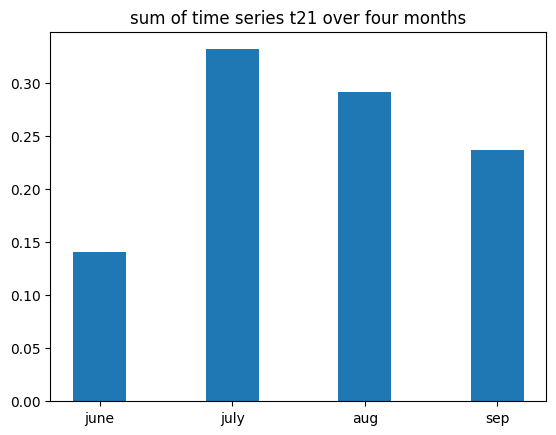

In [32]:
plt.bar(["june","july","aug","sep"], freqBAJJAS/np.sum(freqBAJJAS), width=0.4)
# plt.ylim(0, 0.6)
plt.title("sum of time series t21 over four months")

In [33]:
freqABJJAS = np.zeros(4)
freqBAJJAS = np.zeros(4)

#find the number of non-zero dates of t21 in four months 
freqBAJJAS[0] += np.count_nonzero(t21[0][june]) 
freqBAJJAS[1] += np.count_nonzero(t21[0][july])
freqBAJJAS[2] += np.count_nonzero(t21[0][aug])
freqBAJJAS[3] += np.count_nonzero(t21[0][sep])

Text(0.5, 1.0, 'num of non-zero elements in time series t21 over four months')

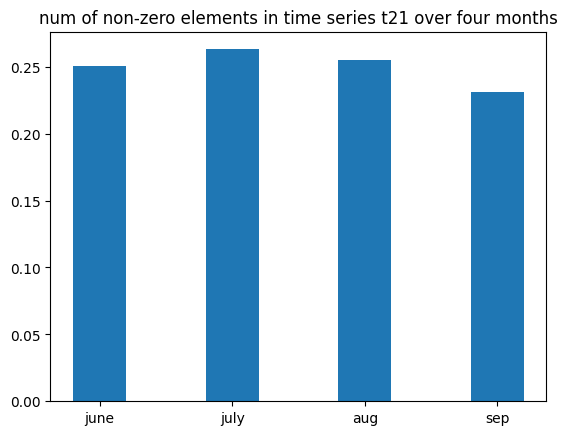

In [34]:
plt.bar(["june","july","aug","sep"], freqBAJJAS/np.sum(freqBAJJAS), width=0.4)
# plt.ylim(0, 0.6)
plt.title("num of non-zero elements in time series t21 over four months")

In [35]:
# apply chebyshev filter to t21+t and find local maximum
cutoff = 10
sth = 90
rmt_21_a = cheby_lowpass_filter(t21[0]+t[0], .95 * 1. / cutoff, 1, 8, .05)
locmax_21_a = np.array(argrelmax(rmt_21_a)[0])
sync_times_21_a = np.intersect1d(locmax_21_a, np.where(rmt_21_a > st.scoreatpercentile(rmt_21_a[JJA], sth))[0])

rmt_12_a = cheby_lowpass_filter(t12[0]+t[0], .95 * 1. / cutoff, 1, 8, .05)
locmax_12_a = np.array(argrelmax(rmt_12_a)[0])
sync_times_12_a = np.intersect1d(locmax_12_a, np.where(rmt_12_a > st.scoreatpercentile(rmt_12_a[JJA], sth))[0])

In [36]:
print(sync_times_12_a, sync_times_21_a)

[ 265  289  625  655  812  888  915  988 1278 1288 1502 1682 1707 2025
 2419 2806 3147 3188 3327 3472 3486 3501 3526 3531 3866 3876 4212 4295
 4576 4595 4606 4629 4643 4925 4940 4982 5005 5345 5367 5495 5513 5645
 5685 5722 5754 6029 6041 6053 6066 6097 6129 6281 6429] [ 207  566  626  758  915 1281 1293 1497 1682 1707 2407 2419 2448 2767
 2806 2848 3149 3179 3327 3488 3505 3528 3547 3836 3864 3876 3907 4214
 4263 4579 4609 4620 4632 4643 4919 4941 4963 4994 5296 5368 5510 5638
 5650 5687 5698 5756 5859 6031 6045 6053 6066 6086 6128 6295 6429 6465
 6751 6767]


In [37]:
freqABJJAS = np.zeros(4)
freqBAJJAS = np.zeros(4)

# find num of local maxima of (t21+t) over four months (above 90 percentile of all JJA)
for i in sync_times_21_a:
    if i in june:
        freqBAJJAS[0] += 1
    if i in july:
        freqBAJJAS[1] += 1
    if i in aug:
        freqBAJJAS[2] += 1
    if i in sep:
        freqBAJJAS[3] += 1


Text(0.5, 1.0, 'num of local maxima of (t21+t) over four months (above 90 percentile of all JJA)')

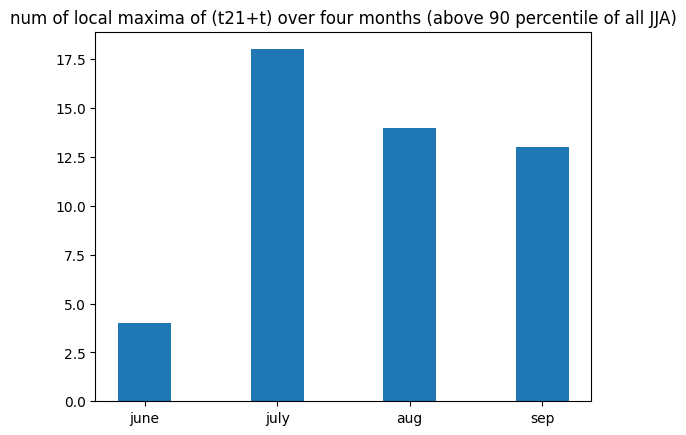

In [38]:
plt.bar(["june","july","aug","sep"], freqBAJJAS, width=0.4)
# plt.ylim(0, 0.6)
plt.title("num of local maxima of (t21+t) over four months (above 90 percentile of all JJA)")

In [39]:
print(sync_times_21_a)
BA_locmax_dict = {}
for i in sync_times_21_a:
    BA_locmax_dict[i] = t21[0][i]
print(BA_locmax_dict.keys())
print(sorted(list(BA_locmax_dict.values()), reverse= True))

[ 207  566  626  758  915 1281 1293 1497 1682 1707 2407 2419 2448 2767
 2806 2848 3149 3179 3327 3488 3505 3528 3547 3836 3864 3876 3907 4214
 4263 4579 4609 4620 4632 4643 4919 4941 4963 4994 5296 5368 5510 5638
 5650 5687 5698 5756 5859 6031 6045 6053 6066 6086 6128 6295 6429 6465
 6751 6767]
dict_keys([207, 566, 626, 758, 915, 1281, 1293, 1497, 1682, 1707, 2407, 2419, 2448, 2767, 2806, 2848, 3149, 3179, 3327, 3488, 3505, 3528, 3547, 3836, 3864, 3876, 3907, 4214, 4263, 4579, 4609, 4620, 4632, 4643, 4919, 4941, 4963, 4994, 5296, 5368, 5510, 5638, 5650, 5687, 5698, 5756, 5859, 6031, 6045, 6053, 6066, 6086, 6128, 6295, 6429, 6465, 6751, 6767])
[102092.0, 91491.0, 74244.0, 47017.0, 46334.0, 44673.0, 37634.0, 37182.0, 33140.0, 32543.0, 29256.0, 28447.0, 28057.0, 27882.0, 27571.0, 27092.0, 24199.0, 21852.0, 21288.0, 20138.0, 18841.0, 18726.0, 18176.0, 17414.0, 16593.0, 16398.0, 15506.0, 14532.0, 13062.0, 12990.0, 12195.0, 11062.0, 11052.0, 11035.0, 10502.0, 9961.0, 9734.0, 9606.0, 9249.0, 

Text(0.5, 1.0, 'time series t21 before filtering vs after filtering')

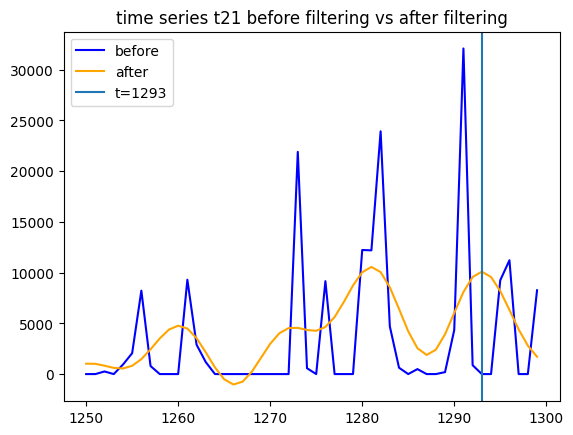

In [40]:
# Note that the effect of Chebyshev filter is not as good as we expected 
# at 1293, see the difference in rmt and t21
plt.plot(range(1250, 1300), t21[0][1250:1300], color = "blue", label = "before")
plt.plot(range(1250, 1300), rmt_21_a[1250:1300], color = "orange", label = "after")
plt.axvline(x = 1293, label = "t=1293")
plt.legend()
plt.title("time series t21 before filtering vs after filtering")

In [41]:
# find the largest number in t21+t without chebyshev filter
t21_sum = t21[0]+t[0]
sync_times_21_a_o = np.where(t21_sum > st.scoreatpercentile(t21_sum[JJA], 99))[0]
print(sync_times_21_a_o)

[ 207  626  758 1291 1497 1682 1683 3506 3527 3876 3908 4215 4580 4608
 4609 4632 4920 4941 5368 5687 5755 6068 6086 6129 6428 6429 6464]


In [42]:
sync_times_21_a_o_JJA = []
for i in sync_times_21_a_o:
    if i in JJA:
        sync_times_21_a_o_JJA.append(i)
print(len(sync_times_21_a_o_JJA))

18
